<a href="https://colab.research.google.com/github/monsegutier/Grupo4/blob/main/GAN_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importación de librerías - 
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [ ]:
# Cargar los datos - 
data = pd.read_excel('/content/02 Customer Churn-Dataset.xlsx')


In [ ]:
# Separar las características numéricas y categóricas - 
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).columns


In [ ]:
# Convertir todas las características categóricas a tipo string - 
data[categorical_features] = data[categorical_features].astype(str)

In [ ]:
# Normalizar las características numéricas
scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])


In [ ]:
# Codificar las características categóricas
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_data = encoder.fit_transform(data[categorical_features])
encoded_features = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_features)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Combinar las características numéricas normalizadas y codificadas con la variable objetivo 'Churn'
processed_data = pd.concat([data[numeric_features], encoded_df, data['Churn']], axis=1)


In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(processed_data.drop(columns=['Churn']), data['Churn'], test_size=0.2, random_state=42)

# Guardar los datos procesados si es necesario
# X_train.to_csv('X_train.csv', index=False)
# X_test.to_csv('X_test.csv', index=False)

Para implementar una Generative Adversarial Network (GAN), necesitamos definir dos redes: el generador y el discriminador. Entrenaremos estas redes de manera adversarial.

**Definir el generador:** El generador toma un vector de ruido como entrada y genera datos similares a los datos de entrenamiento.

**Definir el discriminador:** El discriminador toma datos reales y generados y aprende a distinguir entre ellos.

**Definir la GAN:** Combina el generador y el discriminador para entrenar el generador a través del engaño del discriminador.

**Entrenar la GAN:** Entrena las redes de manera adversarial en un bucle.

In [ ]:
# Instalamos Tensorflow
!pip install tensorflow


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam



In [ ]:
# Dimensión del vector de ruido
latent_dim = 100

# Definir el generador
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(X_train.shape[1], activation='tanh'))
    return model

# Definir el discriminador
def build_discriminator(input_shape):
    model = Sequential()
    model.add(Dense(512, input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model



In [ ]:
# Compilar el discriminador
discriminator = build_discriminator((X_train.shape[1],))
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Construir el generador
generator = build_generator(latent_dim)

# Definir la GAN combinando el generador y el discriminador
z = tf.keras.Input(shape=(latent_dim,))
generated_data = generator(z)
discriminator.trainable = False
validity = discriminator(generated_data)
gan = Model(z, validity)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')


In [ ]:
# Función para entrenar la GAN
def train_gan(epochs, batch_size, sample_interval):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Entrenar el discriminador
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train.iloc[idx].values

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generated_data = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake = discriminator.train_on_batch(generated_data, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Entrenar el generador
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, valid)

        # Imprimir el progreso
        print(f"{epoch + 1}/{epochs} [D loss: {d_loss[0]:.4f}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

        # Si es el intervalo de muestreo, guardar las imágenes generadas
        if (epoch + 1) % sample_interval == 0:
            sample_images(epoch + 1)


La función sample_images en el código está diseñada para generar y mostrar muestras de datos generados por el modelo generador de la GAN en ciertos intervalos durante el entrenamiento. Aunque el nombre de la función sugiere que genera y guarda imágenes, en este caso, dado que estamos trabajando con datos tabulares y no con imágenes, la función simplemente genera y muestra ejemplos de datos sintéticos creados por el generador.

In [ ]:
# Función para generar y guardar muestras de imágenes
def sample_images(epoch):
    noise = np.random.normal(0, 1, (5, latent_dim))
    generated_data = generator.predict(noise)
    # Convertir los datos generados a un DataFrame de pandas
    generated_df = pd.DataFrame(generated_data, columns=X_train.columns)

    # Guardar los datos generados en un archivo CSV
    generated_df.to_csv(f"generated_data_epoch_{epoch}.csv", index=False)

    print(f"Generated data at epoch {epoch} saved to generated_data_epoch_{epoch}.csv")


In [ ]:
# Entrenar la GAN
train_gan(epochs=1000, batch_size=64, sample_interval=1000)

2/2 [==============================] - 0s 35ms/step
1/1000 [D loss: 0.0739, acc.: 98.44%] [G loss: 17.9578]
2/2 [==============================] - 0s 21ms/step
2/1000 [D loss: 0.0575, acc.: 98.44%] [G loss: 18.2251]
2/2 [==============================] - 0s 20ms/step
3/1000 [D loss: 0.1428, acc.: 96.88%] [G loss: 19.8631]
2/2 [==============================] - 0s 19ms/step
4/1000 [D loss: 0.0427, acc.: 99.22%] [G loss: 22.6594]
2/2 [==============================] - 0s 18ms/step
5/1000 [D loss: 0.0277, acc.: 100.00%] [G loss: 20.8905]
2/2 [==============================] - 0s 19ms/step
6/1000 [D loss: 0.0265, acc.: 100.00%] [G loss: 20.6107]
2/2 [==============================] - 0s 20ms/step
7/1000 [D loss: 0.0340, acc.: 99.22%] [G loss: 19.0491]
2/2 [==============================] - 0s 27ms/step
8/1000 [D loss: 0.1656, acc.: 95.31%] [G loss: 19.9180]
2/2 [==============================] - 0s 32ms/step
9/1000 [D loss: 0.0748, acc.: 98.44%] [G loss: 21.8195]
2/2 [=====================

**Generar Nuevos Datos**

Vamos a usar el generador entrenado para crear un nuevo conjunto de datos de churn

In [ ]:
# Función para generar nuevos datos usando el generador entrenado
def generate_new_data(n_samples):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    generated_data = generator.predict(noise)

    # Convertir los datos generados a un DataFrame de pandas
    generated_df = pd.DataFrame(generated_data, columns=X_train.columns)

    return generated_df

# Generar 1000 nuevos ejemplos de datos de churn
new_data = generate_new_data(1000)

# Guardar los datos generados en un archivo CSV
new_data.to_csv("generated_churn_data.csv", index=False)

print("Generated data saved to generated_churn_data.csv")


32/32 [==============================] - 1s 17ms/step
Generated data saved to generated_churn_data.csv


Analizar los Datos Generados
Podemos realizar análisis estadísticos y visualizaciones sobre los datos generados para obtener insights sobre los posibles escenarios de churn.

       SeniorCitizen       tenure  MonthlyCharges  numAdminTickets  \
count    1000.000000  1000.000000     1000.000000      1000.000000   
mean        0.012750     0.121781       -0.070771         0.059237   
std         0.168019     0.289675        0.558725         0.134936   
min        -0.504472    -0.675298       -0.986569        -0.374078   
25%        -0.101280    -0.099071       -0.559677        -0.031403   
50%         0.017450     0.110030       -0.096516         0.054660   
75%         0.121378     0.331607        0.387035         0.145667   
max         0.529605     0.901423        0.989085         0.496697   

       numTechTickets  customerID_0003-MKNFE  customerID_0004-TLHLJ  \
count     1000.000000            1000.000000            1000.000000   
mean         0.061066              -0.027285              -0.024085   
std          0.214475               0.116591               0.136332   
min         -0.521642              -0.406810              -0.514486   
25%         -0

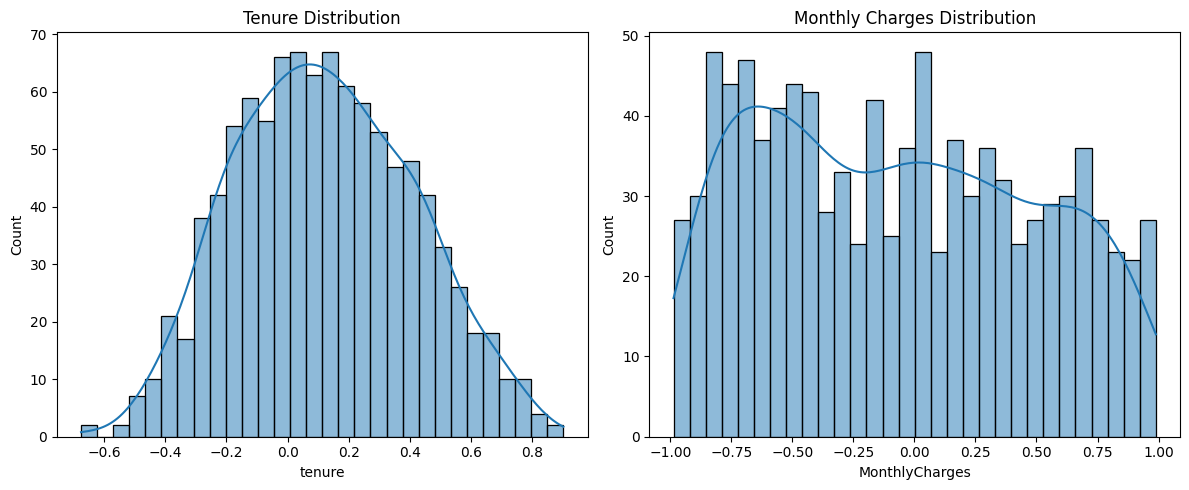

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Descripción estadística de los datos generados
print(generated_data.describe())

# Crear una figura con 1 fila y 2 columnas para las subparcelas
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Primer histograma: Tenure Distribution
sns.histplot(generated_data['tenure'], bins=30, kde=True, ax=axs[0])
axs[0].set_title('Tenure Distribution')

# Segundo histograma: Monthly Charges Distribution
sns.histplot(generated_data['MonthlyCharges'], bins=30, kde=True, ax=axs[1])
axs[1].set_title('Monthly Charges Distribution')

# Ajustar el diseño de las parcelas
plt.tight_layout()
plt.show()


**Evaluar la Calidad de los Datos Generados**
Para evaluar la calidad de los datos generados,  se puede comparar las distribuciones de las variables en los datos generados con las de los datos reales

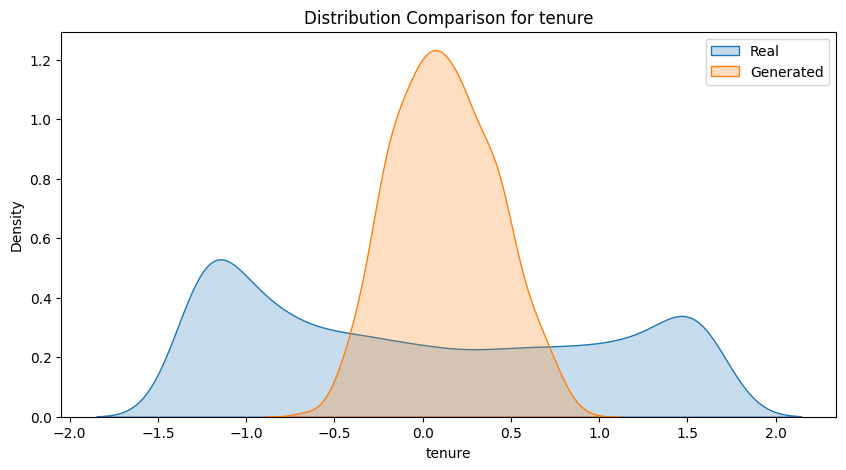

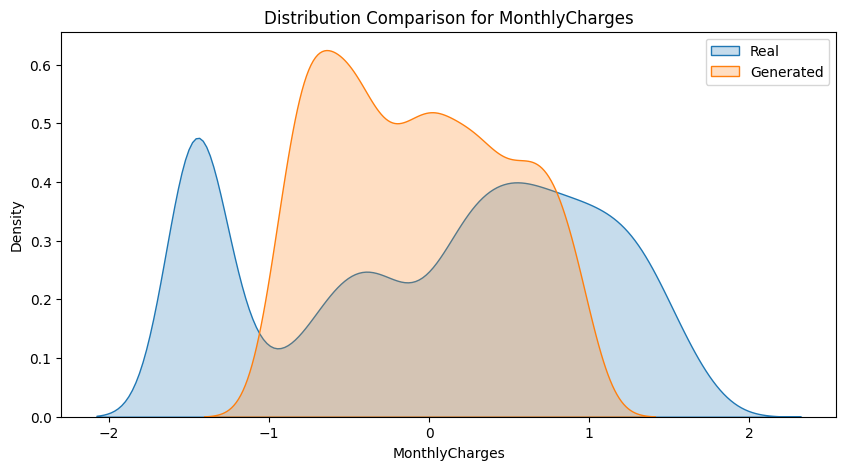

In [ ]:
# Función para comparar distribuciones
def compare_distributions(real_data, generated_data, column):
    if column in real_data.columns and column in generated_data.columns:
        plt.figure(figsize=(10, 5))
        sns.kdeplot(real_data[column], label='Real', fill=True)
        sns.kdeplot(generated_data[column], label='Generated', fill=True)
        plt.title(f'Distribution Comparison for {column}')
        plt.legend()
        plt.show()
    else:
        print(f"La columna '{column}' no existe en ambos conjuntos de datos.")

# Comparar la distribución de 'tenure'
compare_distributions(real_data, generated_data, 'tenure')

# Comparar la distribución de 'MonthlyCharges'
compare_distributions(real_data, generated_data, 'MonthlyCharges')



Pasos a seguir

**1. Revisar la Arquitectura del Modelo**

Tanto el generador como el discriminador deberían tener suficientes capas y neuronas para capturar la complejidad de los datos. Podemos añadir más capas o cambiar el número de neuronas en cada capa.

**2. Ajustar Hiperparámetros**

Dimensión latente (latent_dim): se puede probar con diferentes tamaños del vector de ruido.
Tasa de aprendizaje: Ajustar la tasa de aprendizaje del generador y del discriminador.
Batch size: Experimentar con diferentes tamaños de lotes.

**3. Aumentar el Número de Epochs**
Entrena la GAN por más epochs. Fue entrenada solo por 1000 epochs

**4. Mejorar la Calidad de los Datos de Entrenamiento**

 Los datos inconsistentes o ruidosos pueden afectar el rendimiento del modelo.

**5. Uso de Técnicas de Regularización**

Se puede usar técnicas como Dropout o Batch Normalization en las capas del modelo para mejorar el rendimiento y la estabilidad del entrenamiento.



Ejemplo de código a verificar

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Dropout, Input, BatchNormalization
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Ajustar parámetros
latent_dim = 100
learning_rate = 0.0002
epochs = 5000
batch_size = 64
sample_interval = 1000

# Redimensionar los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)

# Crear el generador
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(X_scaled.shape[1], activation='tanh'))
    return model

# Crear el discriminador
def build_discriminator(input_shape):
    model = Sequential()
    model.add(Dense(512, input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Construir y compilar el generador
generator = build_generator(latent_dim)
generator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate))

# Construir y compilar el discriminador
discriminator = build_discriminator((X_scaled.shape[1],))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

# Construir el modelo GAN
z = Input(shape=(latent_dim,))
generated_data = generator(z)
discriminator.trainable = False
validity = discriminator(generated_data)
gan = Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate))

# Función de entrenamiento
def train_gan(epochs, batch_size, sample_interval):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_scaled.shape[0], batch_size)
        real_data = X_scaled[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generated_data = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake = discriminator.train_on_batch(generated_data, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, valid)

        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            sample_images(epoch)

# Función para generar y guardar muestras de imágenes
def sample_images(epoch):
    noise = np.random.normal(0, 1, (5, latent_dim))
    generated_data = generator.predict(noise)
    generated_df = pd.DataFrame(scaler.inverse_transform(generated_data), columns=X_train.columns)
    generated_df.to_csv(f"generated_data_epoch_{epoch}.csv", index=False)
    print(f"Generated data at epoch {epoch} saved to generated_data_epoch_{epoch}.csv")

# Entrenar la GAN
train_gan(epochs=epochs, batch_size=batch_size, sample_interval=sample_interval)


**Conclusiones**

**La Generative Adversarial Network (GAN)** tiene el potencial de ofrecer una serie de beneficios en el contexto del churn, o la pérdida de clientes, en una empresa.

**Generación de Datos Sintéticos:** La GAN puede generar datos sintéticos que se asemejen a los datos reales de los clientes. Es útil cuando los datos reales son escasos o están desequilibrados, permitiendo así el entrenamiento de modelos de predicción de churn más robustos.

**Exploración de Escenarios de Churn:** Al generar datos sintéticos, la GAN puede ayudar a explorar diferentes escenarios de churn y entender mejor los factores que influyen en la retención de clientes.

**Mejora de Modelos de Predicción:** Los datos sintéticos generados por la GAN pueden utilizarse para mejorar la precisión de los modelos de predicción de churn. Al combinar datos reales con datos generados, se puede ampliar el conjunto de entrenamiento y mejorar la capacidad del modelo para capturar la complejidad de los datos.

**Optimización de Estrategias de Retención:** Con una mejor comprensión de los factores que contribuyen al churn, se pueden desarrollar estrategias de retención más efectivas. La GAN puede ayudar a identificar los segmentos de clientes más propensos a abandonar y diseñar estrategias personalizadas para retenerlos.

GAN ofrece una herramienta poderosa para generar datos sintéticos que pueden mejorar la calidad de los modelos de predicción de churn y proporcionar insights valiosos para la gestión de la retención de clientes.
Al integrar la GAN en el proceso de análisis y toma de decisiones, las empresas de Telcos pueden estar mejor equipadas para enfrentar el desafío del churn y mantener la lealtad de sus clientes.